<a href="https://colab.research.google.com/github/carlos-calderon-cabezas/airbnb-sentiment-analysis/blob/main/airbnb_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An&aacute;lisis de sentimientos para rese&ntilde;as de Airbnb

El presente proyecto aborda una de las aplicaciones m&aacute;s interesantes al momento de trabajar con el **Procesamiento del Lenguage Natural (PLN)** con Python, que consiste en el **An&aacute;lisis de Sentimientos** aplicado a un conjunto de datos reales de muestra correspondientes a 620 rese&ntilde;as otorgadas por hu&eacute;spedes a un total de 10 alojamientos listados dentro de la plataforma de alojamientos temporales *Airbnb* para la ic&oacute;nica ciudad tur&iacute;stica ecuatoriana con playas &uacute;nicas y gente muy acogedora que es **Monta&ntilde;ita**.

Este proyecto cumple con los lineamientos de estilo y formato de código dictados en el manual ***PEP-8***, adem&aacute;s de ***Entidades HTML*** para ayudar a la correcta legibilidad de caracteres especiales, tales como *tildes* y *&ntilde;*.

# Preprocesamiento inicial de la informaci&oacute;n

## Instalaci&oacute;n e importaci&oacute;n de librer&iacute;as necesarias

Debido a que varias de las rese&ntilde;as contienen *emojis*, ser&aacute; necesario contar con una librer&iacute;a para su respectivo tratamiento y transformaci&oacute;n, para posteriormente emplearlos al momento de realizar el an&aacute;lisis de sentimientos. La librer&iacute;a que se instala se llama ***emoji***.

In [ ]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 6.8 MB/s eta 0:00:00


Se importan adem&aacute;s liber&iacute;as como ***pandas***, ***numpy***, ***os***, ***glob*** y ***pathlib***, mismas que servir&aacute;n para diferentes prop&oacute;sitos, desde la manipulaci&oacute;n de archivos y carpetas dentro de la m&aacute;quina virtual hasta la creaci&oacute;n de ***DataFrames*** y el uso de funciones matem&aacute;ticas.

In [ ]:
import pandas as pd
import numpy as np
import os
import glob
from pathlib import Path

Se configura pandas para evitar que trunque el texto de las entradas de cada una de las columnas. Adicionalmente, se cambia el directorio base con la librer&iacute;a ***os*** para una mayor facilidad de trabajo. En el directorio base est&aacute;n contenidas las rese&ntilde;as dejadas por hu&eacute;spedes de un total de 10 alojamientos diferentes ubicados en la playa de Monta&ntilde;ita, Ecuador, con corte a la fecha del viernes, 06 de enero de 2024.

In [ ]:
default_max_colwidth = pd.get_option('display.max_colwidth')
pd.set_option('display.max_colwidth', None)

El bloque de c&oacute;digo contenido en la siguiente celda se debe ejecutar &uacute;nicamente si los archivos del ***notebook*** se almacenan en ***Google Drive*** y si adem&aacute;s este se ejecuta dentro de la plataforma de ***Google Colab***, para lo cual es necesario reemplazar *root_path* con la ruta correspondiente al directorio ra&iacute;z donde se almacenar&aacute;n los archivos. Esto es a fin de que en celdas posteriores no sea necesario escribir la ruta completa cada vez.

Por el contrario, si se ejecuta el ***notebook*** en un entorno local, se puede omitir por completo la celda.

In [ ]:
root_path = "/content/drive/MyDrive/PORTFOLIO/Sent_Analysis"
reviews_path = os.path.join(root_path, "abb_reviews")
os.chdir(root_path)
# Verificación de cambio de directorio
print(f"Directorio actual: {os.getcwd()}")

Directorio actual: /content/drive/MyDrive/PORTFOLIO/Sent_Analysis


Se obtiene un listado con todos los arhivos correspondientes a las rese&ntilde;as de 10 alojamientos en total.

In [ ]:
# Se define un patrón para buscar archivos txt en el directorio
patron = '*.txt'

# Se usa glob para obtener la lista de archivos que coinciden con el patrón
abb_reviews = glob.glob(os.path.join(reviews_path, patron))

# Se ordenan las reseñas en orden alfabético
abb_reviews = sorted(
    abb_reviews,
    key=lambda x: int(Path(x).stem.split('_')[-1]))

## Conteo de rese&ntilde;as por cada archivo

In [ ]:
total_resenas = 0
for archivo in abb_reviews:
    archivo_path = Path(archivo)
    with open(archivo_path, mode="r", encoding="utf-8") as file:
        foo = file.read()
        print(f'Número de reseñas en {archivo_path.name}:\
         {foo.count("Calificación: ")}')
        total_resenas += foo.count("Calificación: ")

print(f"\nTotal de reseñas en {len(abb_reviews)} archivos: {total_resenas}")

Número de reseñas en abb_reviews_00.txt:         9
Número de reseñas en abb_reviews_01.txt:         17
Número de reseñas en abb_reviews_02.txt:         141
Número de reseñas en abb_reviews_03.txt:         15
Número de reseñas en abb_reviews_04.txt:         38
Número de reseñas en abb_reviews_05.txt:         8
Número de reseñas en abb_reviews_06.txt:         200
Número de reseñas en abb_reviews_07.txt:         29
Número de reseñas en abb_reviews_08.txt:         22
Número de reseñas en abb_reviews_09.txt:         141

Total de reseñas en 10 archivos: 620


## Funci&oacute;n para extraer las rese&ntilde;as de hu&eacute;spedes de todos los archivos

Puede verse que parte de la informaci&oacute;n recopilada no est&aacute; previamente estructurada, es decir, hay comentarios con atributos diferentes a otros, tales como, por ejemplo, "*Se qued&oacute; unas semanas*" o "*Con mascota*". Es por esto que dichas expresiones son eliminadas para evitar que sean err&oacute;neamente interpretadas como comentarios.

In [ ]:
def extraer_comentarios(mi_archivo):
    comentarios = []
    with open(mi_archivo, mode="r", encoding="utf-8") as file:
        texto = file.read()

    # Dividir el texto en fragmentos usando "Calificación:" como delimitador
    fragmentos = texto.split("Calificación:")[1:]

    # Eliminación de fragmentos vacíos
    fragmentos = [
        fragmento.strip() for fragmento in fragmentos if fragmento.strip()
    ]
    for fragmento in fragmentos:
        aux = (
            fragmento.replace(",·", "")
            .replace("Se quedó unas semanas", "")
            .replace("Estadía de una semana", "")
            .replace("Con mascota", "")
        )
        aux = "\n".join(
            linea.strip() for linea in aux.splitlines() if linea.strip()
        )
        comentarios.append(aux.splitlines()[2])

    return comentarios

Se crea una lista para en ella guardar todas las rese&ntilde;as (que a su vez est&aacute;n en listas) las cuales serán almacenadas en un ***DataFrame de Pandas*** junto con las calificaciones.

In [ ]:
lista_reviews = []

In [ ]:
for review_file in abb_reviews:
    lista_reviews.append(extraer_comentarios(review_file))

Se verifica con la funci&oacute;n ***len*** que existan efectivamente ***620*** rese&ntilde;as en total, lo cual se cumple, y posteriormente se crea un archvo de texto plano para verificar los comentarios.

In [ ]:
print(len(sum(lista_reviews, [])))

620


Se guardan todas las rese&ntilde;as en un archivo de texto para comprobar de manera manual mediante un editor de textos externo que cada una de las 620 l&iacute;neas correspondientes a comentarios son efectivamente comentarios y no otros de los atributos de las rese&ntilde;as.

In [ ]:
if not os.path.exists("processing/coment_ALL.txt"):
    with open("processing/coment_ALL.txt", mode="w") as file:
        file.write("\n".join(sum(lista_reviews, [])))

## Funci&oacute;n para extraer las calificaciones de hu&eacute;spedes de todos los archivos

Adicionalmente, para el an&aacute;lisis de sentimientos es importante extraer la calificaci&oacute;n del 1 al 5 que dieron los usuarios en cada una de las rese&ntilde;as para contrastarlas con el resultado del an&aacute;lisis de sentimientos. Al igual que con los comentarios en s&iacute;, las puntuaciones se almacenan tambi&eacute;n en formato de listas para despu&eacute;s crear un ***DataFrame de Pandas*** con estas.

In [ ]:
def extraer_calificaciones(mi_archivo):
    stars = []
    with open(mi_archivo, mode="r", encoding="utf-8") as file:
        texto = file.read()
        fragmentos = texto.split("Calificación: ")

    for i in range(1, len(fragmentos)):
        stars.append(int(fragmentos[i][0]))

    return stars

In [ ]:
lista_stars = []

for review_file in abb_reviews:
    lista_stars.append(extraer_calificaciones(review_file))

Se verifica que la cantidad de calificaciones sea la misma que de comentarios.

In [ ]:
len(sum(lista_stars, []))

620

Se crean los &iacute;ndices para identificar a cada uno de los 10 alojamientos previo a la creaci&oacute;n del *DataFrame* de *Pandas*. As&iacute;mismo, se unen todos los elementos de rese&ntilde;as y n&uacute;mero de estrellas de cada alojamiento en una &uacute;nica lista para cada caso.

In [ ]:
def unir_listas(lista):
    return sum(lista, [])

In [ ]:
numero_resenas = []

In [ ]:
for resena in lista_reviews:
    numero_resenas.append(len(resena))

In [ ]:
numero_resenas

[9, 17, 141, 15, 38, 8, 200, 29, 22, 141]

In [ ]:
id_alojamiento = []
for index, i in enumerate(numero_resenas, start=0):
    id_alojamiento.append(list(np.full(i, index)))

id_alojamiento = sum(id_alojamiento, [])

In [ ]:
lista_reviews = unir_listas(lista_reviews)
lista_stars = unir_listas(lista_stars)

## Construcci&oacute;n de DataFrame de Pandas

In [ ]:
df_reviews = pd.DataFrame({
    "id_alojamiento": id_alojamiento,
    "review": lista_reviews,
    "stars": lista_stars,
})

Se realiza un muestreo a fin de verificar que el *DataFrame* fue construido de manera correcta y se procede a guardar el mismo en formato *csv* para uso futuro.

In [ ]:
df_reviews.sample(5)

,id_alojamiento,review,stars
369,6,This is a good value in Montanita. It is a good location away from the central chaos but a close walk. It has AC and a nice view.,5
50,2,Excelente y jonny es muy chevere. Tiene buena energia,5
206,4,"Aparte de ser un lugar increíble, acogedor, perfectamente ubicado para poder disfrutar de una vista maravillosa del mar, también cuenta con una host fenomenal como Tania, quien fue muy atenta con nosotros. Muy gustosa nos hizo un mini tour de lugares deliciosos para comer, o disfrutar de cócteles frente al atardecer. Hospedarse aquí es una experiencia que de seguro querrás volver a vivir. Recomendadísimo!!",5
270,6,"La verdad no le doy las 5 estrellas porque la cama estaba con algo de polvo y sería recomendable cambiar o lavar y aspirar porque mi novia y yo tuvimos alergias. El otro detalle es que el camino de ma entrada estuvo algo peligroso en caso de lluvia y mucha maleza a los lados que provocan mosquitos, de ahí todo perfecto me gusto porque es acogedor, pude hubo una vista muy linda",3
451,7,"Such a cool spot. I am a woman traveling alone through Ecuador from the US and this was one of my favorite spots. The place is so stylish and unique, it represented the best parts of travel. While not luxurious in a traditional sense (composting toilet and cold shower) it offers a sort of opulence that is much harder to find. My room was huge and had a private balcony looking over the town of Montanita and the coast. Hammocks in the the room and on the balcony and lots of little handmade tables for a drink and a book (superfluous furniture is definitely a luxury in Ecuador). Beautiful wood floors and abundant windows. The wi-fi was great and the noise from Montanita very minimal. I highly recommend having an adventure at this glorious and unforgettable hostel!",5


In [ ]:
if not os.path.exists("processing/df_reviews.csv"):
    df_reviews.to_csv("processing/df_reviews.csv", index=False)

A continuaci&oacute;n, se procede a traducir las rese&ntilde;as dejadas por los hu&eacute;spedes a los alojamientos con la ayuda de **Google Cloud Translate**, el cual detecta de manera autom&aacute;tica el idioma de los textos de entrada y los traduce al ingl&eacute;s a fin de procesarlos posteriormente al momento de realizar el an&aacute;lisis de sentimientos.

Para las ejecuciones posteriores del presente *Jupyter Notebook*, se importa el archivo con las rese&ntilde;as ya traducidas a fin de no exceder la cuota de traducciones permitidas en la capa gratuita de *Google Cloud Translate*.

En caso de que se quiera replicar el uso de ***Google Cloud Translate*** para la traducci&oacute;n autom&aacute;tica de textos se deber&aacute; utilizar una cuenta existente de ***Google Cloud*** o crear una nueva cuenta y generar las credenciales de acceso a la API, siguiendo para ello la documentaci&oacute;n del proveedor de servicios en la nube.

La raz&oacute;n por la cual se almacenan los datos en formato *.xlsx* en lugar de *.csv* radica en que en algunas ocasiones el int&eacute;rprete de ***Pandas*** confunde ciertos caracteres especiales con delimitadores de datos y se produce una lectura err&oacute;nea para algunos de los registros.

In [ ]:
df_traducciones = pd.DataFrame()

In [ ]:
from google.cloud import translate_v2 as translate

# Lectura de llave privada de la API de Google Cloud Translate
client = translate.Client.from_service_account_json(
    "processing/private_key_translate.json"
)

if not os.path.exists("translations/df_reviews_traducido.xlsx"):
    # Función para traducir un texto
    def translate_text(text, target_language='en'):
        result = client.translate(text, target_language=target_language)
        return result['translatedText']

    # Traducción de texto en la columna "review"
    df_reviews['texto_traducido'] = df_reviews["review"].apply(
        lambda x: translate_text(x, target_language="en")
    )

    # Almacenamiento de reseñas traducidas para uso futuro
    df_reviews[[
            "id_alojamiento", "review", "texto_traducido", "stars"
        ]].to_excel(
        "translations/df_reviews_traducido.xlsx", index=False
    )

else:
    df_reviews['texto_traducido'] = pd.read_excel(
        "translations/df_reviews_traducido.xlsx"
    )["texto_traducido"]

Se obtiene una muestra aleatoria de los datos a fin de verificar las traducciones realizadas.

In [ ]:
df_reviews.sample(10)

,id_alojamiento,review,stars,texto_traducido
11,1,I don't think this should be listed on Airbnb as an entire apartment. It's a very small motel room (one of many) with a sink in the corner and an open space outside. There is a shared outdoor kitchen.,3,I don't think this should be listed on Airbnb as an entire apartment. It's a very small motel room (one of many) with a sink in the corner and an open space outside. There is a shared outdoor kitchen.
494,9,Great place! Everything was as advertised. Response from the host is fast and accurate. Would visit here again!,5,Great place! Everything was as advertised. Response from the host is fast and accurate. Would visit here again!
612,9,"My husband and I enjoyed our days on Gijs & Liliana apartment. It's a beautiful and quiet place on Manglaralto, where you can rest. It's 15 minutes near Montañita and only 5 minutes near the beach.",5,"My husband and I enjoyed our days on Gijs & Liliana apartment. It's a beautiful and quiet place on Manglaralto, where you can rest. It's 15 minutes near Montañita and only 5 minutes near the beach."
536,9,We had as good a stay as possible at the lovely apartment of Gijs and Liliana's place in Manglaralto. A cute place with everything we needed. A very comfortable bed and pillows.,5,We had as good a stay as possible at the lovely apartment of Gijs and Liliana's place in Manglaralto. A cute place with everything we needed. A very comfortable bed and pillows.
128,2,"Muy bueno apartamento : ubicaccion, vista sobre la playa, aire accondicionado, buena cama, todo bien.",5,"Very good apartment: location, view of the beach, air conditioning, good bed, everything good."
399,6,Práctico para quedarse un par de noches. Buena respuesta del anfitrión.,4,Practical to stay a couple of nights. Good response from the host.
220,5,El anfitrión fue muy amable desde el principio hasta el final. El alojamiento se encuentra muy cerca a la playa y a la zona de restaurantes y bares por lo cual es una buena opción.,5,"The host was very friendly from start to finish. The accommodation is very close to the beach and the area of restaurants and bars, making it a good option."
13,1,"Great place! Close to the beach, nice outside kitchen, quiet at night, budget friendly. Enjoy!",5,"Great place! Close to the beach, nice outside kitchen, quiet at night, budget friendly. Enjoy!"
351,6,"This is the second time I have stayed here and it was as enjoyable as the first. This is a very cozy nice,place to stay. I highly recommend it.",5,"This is the second time I have stayed here and it was as enjoyable as the first. This is a very cozy nice,place to stay. I highly recommend it."
517,9,Lugar muy acogedor y todo ordenado. Siempre estuvieron pendientes de uno,5,Very cozy place and everything tidy. They were always looking out for you


# Preparaci&oacute;n de los datos para el Análisis de Sentimientos

##: Elminaci&oacute;n de signos de puntuaci&oacute;n, art&iacute;culos y palabras innecesarias:

Se importa la librer&iacute;a **nltk** detectar y eliminar de los comentarios dejados por los hu&eacute;spedes y traducidos previamente al ingl&eacute;s, los art&iacute;culos, palabras y signos de puntuaci&oacute;n que no van a ser de utilidad al momento de realizar el an&aacute;lisis de sentimientos, y se almacena en una nueva columna del *DataFrame* llamada "*texto_sin_stopwords*".

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')


def remover_articulos(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df_reviews["texto_sin_stopwords"] = df_reviews["texto_traducido"].apply(
    lambda x: remover_articulos(x)
)

Se ocupan adem&aacute;s expresiones regulares para dar tratamientos tanto a los espacios sobrantes como a los signos de puntuaci&oacute;n y caracteres innecesarios para el an&aacute;lisis de sentimientos. Adem&aacute;s se preparan los datos para el tratamiento de emojis.

In [ ]:
import re


def extraer_no_letras(texto):
    return list(set(re.sub('[a-zA-Z0-9]', '', texto)))

In [ ]:
df_reviews["no_texto"] = df_reviews["texto_sin_stopwords"].apply(
    lambda x: extraer_no_letras(x)
)

In [ ]:
non_text_chars = list(set(df_reviews["no_texto"].sum()))
non_text_chars.remove(" ")
df_reviews.drop(["no_texto"], axis=1, inplace=True)

## Tratamiento de emojis

Se extrae de la variable definida anteriormente "*non_text_chars*", una lista de todos los emojis presentes en las rese&ntilde;as otorgadas por los hu&eacute;spedes.

Adicionalmente, se asigna una palabra en ingl&eacute;s para dar una interpretaci&oacute;n adecuada a cada uno de estos.

Por &uacute;ltimo, se reemplazan los emojis con sus equivalentes en palabras.

In [ ]:
import emoji

emojis_list = [i for i in non_text_chars if emoji.is_emoji(i)]
emojis_dict = {
    '✨': 'sparkling',
    '🙃': 'sarcastic',
    '💖': 'beautiful',
    '😔': 'sad',
    '🙌': 'celebration',
    '😘': 'affectionate',
    '⭐': 'star',
    '👏': 'applause',
    '💕': 'affectionate',
    '😊': 'happy',
    '😍': 'admiration',
    '💓': 'emotion',
    '❣': 'emotion',
    '💜': 'affection',
    '🙈': 'playful',
    '🤗': 'friendly',
    '👌': 'approval',
    '🏻': '',
    '🍻': 'celebration',
    '🌞': 'cheerful',
    '❤': 'love',
    '♥': 'love',
    '💯': 'perfect',
    '👍': 'approval'
}

In [ ]:
non_emoji_chars = [i for i in non_text_chars if not emoji.is_emoji(i)]

In [ ]:
def quitar_simbolos(texto):
    for char in non_emoji_chars:
        texto = texto.replace(char, "")
    return texto

In [ ]:
df_reviews["texto_sin_stopwords"] = df_reviews["texto_sin_stopwords"].apply(
    lambda x: quitar_simbolos(x)
)

In [ ]:
df_reviews["texto_sin_stopwords"] = df_reviews["texto_sin_stopwords"].apply(
    lambda x: " ".join(x.split())
)

Se define una funci&oacute;n para reemplazar los emojis por sus equivalentes en palabras.

In [ ]:
def reemplazar_emojis(texto):
    for (key, value) in emojis_dict.items():
        texto = texto.replace(key, f" {value} ")
    return texto

In [ ]:
df_reviews["texto_sin_emojis"] = df_reviews["texto_sin_stopwords"].apply(
    lambda x: reemplazar_emojis(x)
)
df_reviews["texto_sin_emojis"] = df_reviews["texto_sin_emojis"].apply(
    lambda x: " ".join(x.split())
)

Se verifican dos comentarios que contienen emojis para evidenciar que la eliminaci&oacute;n de *stopwords* y el reemplazo de emojis por ***palabras equivalentes*** se realiz&oacute; correctamente, y finalmente se guarda esta versi&oacute;n del *DataFrame* limpia de emojis en un archivo de Microsoft Excel.

In [ ]:
df_reviews[["texto_traducido", "texto_sin_stopwords", "texto_sin_emojis"]] \
    .iloc[[76, 263], :]

,texto_traducido,texto_sin_stopwords,texto_sin_emojis
76,"Everything is very nice, safe and cozy😊",Everything nice safe cozy😊,Everything nice safe cozy happy
263,A quiet place with a good location. They are pet friendly 😊,quiet place good location pet friendly 😊,quiet place good location pet friendly happy


In [ ]:
if not os.path.exists("processing/df_limpio_emojis.xlsx"):
    df_reviews.to_excel("processing/df_limpio_emojis.xlsx")

# Análisis de Sentimientos

Finalmente, se procede a realizar un ***an&aacute;lisis de sentimientos*** de todos los comentarios presentes, para lo cual se importa la librer&iacute;a ***nltk*** y se utiliza el componente ***vader_lexicon*** para el an&aacute;lisis de polaridad en cada uno de los comentarios.

En primer lugar, se define una funci&oacute;n que clasifica los coemntarios en base a su polaridad en las categor&iacute;s de **Positivo**, **Negativo** o **Neutral**, y mediante una funci&oacute;n *lambda* se env&iacute;an los resultados a una nueva columna del ***DataFrame de Pandas***.

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def clasificar_comentario(comentario):
    polaridad = sia.polarity_scores(comentario)['compound']
    if polaridad > 0.05:
        return "Positivo"
    elif polaridad < -0.05:
        return "Negativo"
    else:
        return "Neutral"

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
df_reviews["Sentimiento"] = df_reviews["texto_sin_emojis"].apply(
    lambda x: clasificar_comentario(x)
)

Muestra de las columnas correspodientes a los ***comentarios traducidos al ingl&eacute;s*** y a los ***sentimientos detectados***.

In [ ]:
df_reviews[["texto_sin_emojis", "Sentimiento"]].sample(3)

,texto_sin_emojis,Sentimiento
588,Lovely place quiet location town minutes walk popular town hosts caring flat advertised good kitchen utensils,Positivo
410,mini apartment described Cute little place everything need plus incredible view looking town ocean Really enjoyed time,Positivo
335,nice place away noise nice view comfortable good facilities within,Positivo


De manera adicional se traducen de manera opcional las rese&ntilde;as al espa&ntilde;ol a fin de realizar una clasificaci&oacute;n manual de los sentimientos que se esperar&iacute;a en cada caso.

In [ ]:
from google.cloud import translate_v2 as translate

# Lectura de llave privada de la API de Google Cloud Translate
client = translate.Client.from_service_account_json(
    "processing/private_key_translate.json"
)

if not os.path.exists("translations/df_reviews_traducido_es.xlsx"):
    # Función para traducir un texto
    def translate_text(text, target_language='es'):
        result = client.translate(text, target_language=target_language)
        return result['translatedText']

    # Traducción de texto en la columna "review"
    df_reviews['texto_traducido_es'] = df_reviews["review"].apply(
        lambda x: translate_text(x, target_language="es")
    )

    # Almacenamiento de reseñas traducidas para uso futuro
    df_reviews[[
            "id_alojamiento", "review", "texto_traducido", "stars"
        ]].to_excel(
        "translations/df_reviews_traducido_es.xlsx", index=False
    )

else:
    df_reviews['texto_traducido_es'] = pd.read_excel(
        "translations/df_reviews_traducido_es.xlsx"
    )["texto_traducido"]

In [ ]:
if not os.path.exists("output/sentimientos.xlsx"):
    df_reviews.to_excel("output/sentimientos.xlsx", index= False)

Se restaura el ancho m&aacute;ximo de columnas que se muestran en el ***DataFrame de Pandas*** para una mejor visualizaci&oacute;n.

In [ ]:
pd.set_option('display.max_colwidth', default_max_colwidth)

Se eval&uacute;a de manera manual la polaridad *'real'* de las rese&ntilde;as a fin de poder crear una matriz de confusi&oacute;n y realizar un an&aacute;lisis de la exactitud de este modelo.

Sin embargo, es importante tener en cuenta que este an&aacute;lisis de la polaridad *'real'* o de conjunto de datos de validaci&oacute;n  est&aacute; sujeto al criterio de la persona que lo realiza, por lo cual no se puede considerar en ning&uacute;n momento como un modelo libre de sesgos e interpretaciones.

In [ ]:
df_sentiments = pd.read_excel("output/matriz_sentimientos.xlsx")
df_sentiments = df_sentiments[["Sentimiento", "Real"]]

In [ ]:
df_sentiments.sample(5)

,Sentimiento,Real
305,Positivo,Positivo
77,Neutral,Neutral
292,Positivo,Positivo
217,Positivo,Positivo
245,Negativo,Negativo


In [ ]:
categorias = df_sentiments["Sentimiento"].unique()
categorias

array(['Positivo', 'Negativo', 'Neutral'], dtype=object)

## Matriz de confusi&oacute;n

Se crea la matriz de cunfusi&oacute;n de tres categor&iacute;as con la ayuda de ***sklearn.metrics.confusion_matrix*** en base a las tres categor&iacute;as de sentimientos definidas con anterioridad.

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
conf_matrix = confusion_matrix(
    df_sentiments["Real"],
    df_sentiments["Sentimiento"],
    labels=categorias
)

conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=categorias,
    columns=categorias
)

In [ ]:
conf_matrix_df

,Positivo,Negativo,Neutral
Positivo,536,1,15
Negativo,8,10,3
Neutral,29,5,13


Se procede a representar la matriz de confusi&oacute;n de 3 dimensiones de manera gr&aacute;fica, mediante las liber&iacute;as ***seaborn*** y ***matplotlib***.

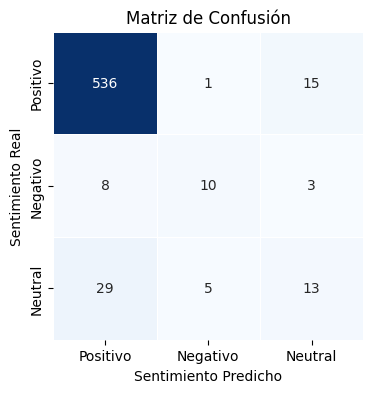

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
sns.heatmap(
    conf_matrix_df,
    annot=True,
    fmt="d",
    cmap="Blues",
    linewidths=.5,
    cbar=False
)

plt.title('Matriz de Confusión')
plt.xlabel('Sentimiento Predicho')
plt.ylabel('Sentimiento Real')
plt.savefig("output/conf_matrix.png")
plt.show()

# Conclusi&oacute;n

El análisis de sentimientos aplicado a las reseñas de Airbnb ha demostrado ser una herramienta poderosa para entender la percepción de los huéspedes. En este estudio, se observó una clara predominancia de comentarios positivos, lo cual es un buen indicativo de la satisfacción general de los clientes. Sin embargo, es crucial profundizar en los detalles que estos comentarios revelan.

## Análisis de Comentarios Positivos
El modelo ha clasificado con alta precisión los sentimientos positivos. Los aspectos más mencionados incluyen:
- **Ubicación**: Los huéspedes valoran altamente la proximidad a la ciudad y las atracciones turísticas.
- **Comodidad**: Comentarios frecuentes sobre la comodidad y acogida de los alojamientos.

### Ejemplo de Comentarios Positivos:
- "El lugar es súper chévere, acogedor y está cerca de la ciudad."
- "Me encantó la comodidad del alojamiento y la proximidad a las principales atracciones."

### Recomendaciones para Anfitriones:
- **Estrategia de Marketing**: Enfocar las campañas publicitarias en destacar la ubicación y la comodidad de los alojamientos.
- **Optimización de Anuncios**: Utilizar palabras clave positivas en las descripciones de los anuncios para atraer más huéspedes.

## Análisis de Comentarios Negativos
El modelo presenta mayor porcentaje de error en la clasificación de comentarios negativos y neutrales. Los aspectos negativos más mencionados incluyen:
- **Limpieza**: Comentarios frecuentes sobre la limpieza insuficiente de los alojamientos.
- **Ruido**: Quejas sobre el ruido en los alrededores del alojamiento.

### Ejemplo de Comentarios Negativos:
- "El lugar estaba sucio y no se limpió adecuadamente."
- "Había mucho ruido, lo que hizo difícil descansar."

### Recomendaciones para Anfitriones:
- **Mejora de Servicios**: Aumentar las horas de limpieza y asegurar una limpieza más profunda entre las estancias.
- **Gestión del Ruido**: Implementar medidas para reducir el ruido, como ventanas insonorizadas o informar a los huéspedes sobre las horas de silencio.

## Valor Comercial del Análisis
Este análisis ofrece un valor significativo tanto para Airbnb como para los anfitriones al proporcionar una visión clara de las áreas de mejora y las fortalezas a destacar. Al implementar estas recomendaciones, los anfitriones pueden mejorar la satisfacción del cliente, aumentar las reservas y fortalecer la reputación de sus alojamientos.

